In [1]:
# Import all of the python packages used in this workflow.
import numpy as np
from collections import OrderedDict
import os, sys
from pylab import *
import pandas as pd
import numpy as np
import osr
import xarray as xr
import geopandas as gpd
from datetime import datetime
from datetime import timedelta  
import json
import itertools
import requests
from sklearn.metrics import r2_score
import time

In [2]:
########## USER ###########
# Select modeling domain ('WY', 'UT', 'OR', 'WA')
domain = 'UT'

# SM location 
SMpath = '/nfs/attic/dfh/Aragon2/CSOsm/jan2021_snowmodel-dfhill_'+domain+'/'

metFname = 'mm_'+domain+'_2011-2016.dat'

In [3]:
dataPath = '/nfs/attic/dfh/Aragon2/CSOdmn/'+domain+'/'
# Outfile path
outpath = '/nfs/attic/dfh/Aragon2/CSOcal/'+domain+'/'

#path to CSO domains
domains_resp = requests.get("https://raw.githubusercontent.com/snowmodel-tools/preprocess_python/master/CSO_domains.json")
domains = domains_resp.json()

#start date    
st_dt = domains[domain]['st']
#end date
ed_dt = domains[domain]['ed']

#Snotel bounding box
Bbox = domains[domain]['Bbox']

# Snotel projection
stn_proj = domains[domain]['stn_proj']
# model projection
mod_proj = domains[domain]['mod_proj']

# Import CSO gdf (metadata) and df (daily SWE data) 

In [7]:
gdf = gpd.read_file(dataPath+ 'CSO_SNOTEL_sites_'+domain+'.geojson')
df = pd.read_csv(dataPath+'SNOTEL_'+domain+'_SWEDmeters'+st_dt+'_'+ed_dt+'.csv') 
gdf.head()

,code,longitude,latitude,name,elevation_m,easting,northing,geometry
0,314_WY_SNTL,-110.445442,43.940189,Base Camp,2151.887939453125,544505.845453,4.865379e+06,POINT (-110.44544 43.94019)
1,347_MT_SNTL,-111.128029,44.508320,Black Bear,2490.216064453125,489823.440274,4.928341e+06,POINT (-111.12803 44.50832)
2,350_WY_SNTL,-109.793327,44.376671,Blackwater,2980.944091796875,596129.923439,4.914418e+06,POINT (-109.79333 44.37667)
3,353_WY_SNTL,-110.609734,42.964001,Blind Bull Sum,2636.52001953125,531828.554679,4.756891e+06,POINT (-110.60973 42.96400)
4,419_WY_SNTL,-110.814819,42.645901,Cottonwood Creek,2337.81591796875,515180.157295,4.721511e+06,POINT (-110.81482 42.64590)


# Import baseline .par parameters 

In [12]:
#path to base par
basepar_resp = requests.get("https://raw.githubusercontent.com/snowmodel-tools/calibration_python/master/par_base.json")
base = basepar_resp.json()
#set par to baseline 
for key in base:
    edit_par(base,key,base[key][0],parFile)
base.keys()

dict_keys(['nx', 'ny', 'deltax', 'deltay', 'xmn', 'ymn', 'dt', 'iyear_init', 'imonth_init', 'iday_init', 'xhour_init', 'max_iter', 'isingle_stn_flag', 'igrads_metfile', 'met_input_fname', 'undef', 'ascii_topoveg', 'topoveg_grads_fname', 'topo_ascii_fname', 'veg_ascii_fname', 'ved_shd_25', 'ved_shd_26', 'ved_shd_27', 'ved_shd_28', 'ved_shd_29', 'ved_shd_30', 'const_veg_flag', 'iveg_ht_flag', 'xlat', 'lat_solar_flag', 'UTC_flag', 'run_micromet', 'run_enbal', 'run_snowpack', 'run_snowtran', 'irun_data_assim', 'ihrestart_flag', 'i_dataassim_loop', 'ihrestart_inc', 'i_tair_flag', 'i_rh_flag', 'i_wind_flag', 'i_solar_flag', 'i_longwave_flag', 'i_prec_flag', 'ifill', 'iobsint', 'dn', 'barnes_lg_domain', 'n_stns_used', 'snowmodel_line_flag', 'check_met_data', 'curve_len_scale', 'slopewt', 'curvewt', 'curve_lg_scale_flag', 'windspd_min', 'lapse_rate_user_flag', 'iprecip_lapse_rate_user_flag', 'iprecip_scheme', 'snowfall_frac', 'wind_lapse_rate', 'calc_subcanopy_met', 'gap_frac', 'cloud_frac_fac

# Function to edit text files 
## Edit snowmodel.par and snowmodel.inc to run SnowModel as line -> original code

In [8]:
#function to edit SnowModel Files other than .par
def replace_line(file_name, line_num, text):
    lines = open(file_name, 'r').readlines()
    lines[line_num] = text
    out = open(file_name, 'w')
    out.writelines(lines)
    out.close()

In [ ]:
# sumlai = 1
# replace_line(micrometFile, 3336,'      data vlai_summer /2.5, 2.5, 2.5, 1.5, 1.0/\n')
# winlai = 2
# replace_line(micrometFile, 3337,'      data vlai_winter /2.5, 0.5, 1.5, 1.5, 1.0/\n')


# Functions to adjust calibraiton parameters
## Edit snowmodel.par to run SnowModel as line -> Dave's code

In [158]:
parFile = SMpath+'snowmodel.par'
incFile = SMpath+'code/snowmodel.inc'
compileFile = SMpath+'code/compile_snowmodel.script'
sweFile = SMpath+'outputs/wo_assim/swed.gdat'
micrometFile = SMpath+'code/micromet_code.f'
ctlFile = SMpath+'ctl_files/wo_assim/swed.ctl'
codepath = SMpath+'code'
calpath = '/nfs/attic/dfh/Aragon2/Notebooks/calibration_python'

In [10]:
#Edit the par file to set parameters with new values
def edit_par(par_dict,parameter,new_value,parFile):
    lines = open(parFile, 'r').readlines()
    if par_dict[parameter][2] == 14 or par_dict[parameter][2] == 17 \
    or par_dict[parameter][2] == 18 or par_dict[parameter][2] == 19 \
    or par_dict[parameter][2] == 93 or par_dict[parameter][2] == 95 \
    or par_dict[parameter][2] == 97 or par_dict[parameter][2] == 100 \
    or par_dict[parameter][2] == 102 or par_dict[parameter][2] == 104 \
    or par_dict[parameter][2] == 107 or par_dict[parameter][2] == 108 \
    or par_dict[parameter][2] == 147 or par_dict[parameter][2] == 148 \
    or par_dict[parameter][2] == 149:
        text = str(new_value)+'\n'
    else:
        text = str(new_value)+'\t\t\t!'+par_dict[parameter][1]
    lines[par_dict[parameter][2]] = text
    out = open(parFile, 'w')
    out.writelines(lines)
    out.close()

In [14]:
# with open('/nfs/attic/dfh/Aragon2/CSOdmn/par_base.json') as f:
#     base = json.load(f)
# #set par to baseline 
# for key in base:
#     edit_par(base,key,base[key][0],parFile)
# #base.keys()

In [102]:
#edit snowmodel.par to run SM as a line 
# spatial inputs
edit_par(base,'nx',np.shape(gdf)[0],parFile)
edit_par(base,'ny',1,parFile)
edit_par(base,'xmn',domains[domain]['xll'],parFile)
edit_par(base,'ymn',domains[domain]['yll'],parFile)
edit_par(base,'deltax',domains[domain]['cellsize'],parFile)
edit_par(base,'deltay',domains[domain]['cellsize'],parFile)
# temporal inputs
edit_par(base,'dt',21600,parFile) #seconds per model time step
edit_par(base,'iyear_init',datetime.strptime(st_dt,'%Y-%m-%d').year,parFile)
edit_par(base,'imonth_init',datetime.strptime(st_dt,'%Y-%m-%d').month,parFile)
edit_par(base,'iday_init',datetime.strptime(st_dt,'%Y-%m-%d').day,parFile)
edit_par(base,'xhour_init',datetime.strptime(st_dt,'%Y-%m-%d').hour,parFile)
edit_par(base,'max_iter',(datetime.strptime(ed_dt,'%Y-%m-%d')-
    datetime.strptime(st_dt,'%Y-%m-%d')).days*4+4,parFile)
# paths 
edit_par(base,'met_input_fname','../../CSOdmn/'+domain+'/'+metFname,parFile)
edit_par(base,'ascii_topoveg',1,parFile)
edit_par(base,'topo_ascii_fname','../../CSOdmn/'+domain+'/DEM_'+domain+'_line.asc',parFile)
edit_par(base,'veg_ascii_fname','../../CSOdmn/'+domain+'/NLCD2016_'+domain+'_line.asc',parFile)
edit_par(base,'lat_file_path','../../CSOdmn/'+domain+'/grid_lat_'+domain+'_line.asc',parFile)
edit_par(base,'lon_file_path','../../CSOdmn/'+domain+'/grid_lon_'+domain+'_line.asc',parFile)
edit_par(base,'snowmodel_line_file','../../CSOdmn/'+domain+'/snowmodel_line_pts.dat',parFile)
#other flags to calibrate SM as line
edit_par(base,'xlat',round(domains[domain]['Bbox']['latmin']+(domains[domain]['Bbox']['latmax']-domains[domain]['Bbox']['latmin'])/2,2),parFile)
edit_par(base,'run_snowtran',0,parFile)
edit_par(base,'barnes_lg_domain',1,parFile)
edit_par(base,'lat_solar_flag',1,parFile)
edit_par(base,'snowmodel_line_flag',1,parFile)
edit_par(base,'print_inc',4,parFile)
edit_par(base,'print_var_01','n',parFile)#tair
edit_par(base,'print_var_09','n',parFile)#prec
edit_par(base,'print_var_10','n',parFile)#rain
edit_par(base,'print_var_11','n',parFile)#sprec
edit_par(base,'print_var_12','n',parFile)#swemelt
edit_par(base,'print_var_14','n',parFile)#runoff
edit_par(base,'print_var_18','y',parFile)#swed
edit_par(base,'cf_precip_flag',3,parFile)
edit_par(base,'UTC_flag',1,parFile)

##edit snowmodel.inc
replace_line(incFile, 12, '      parameter (nx_max='+str(np.shape(gdf)[0]+1)+',ny_max=2)\n')
#replace_line(incFile, 12, '      parameter (nx_max=1383,ny_max=2477)\n')#full domain


##edit compile_snowmodel.script
#replace_line(compileFile, 16, '#pgf77 -O3 -mcmodel=medium -I$path -o ../snowmodel $path$filename1 $path$filename2 $path$filename3 $path$filename4 $path$filename5 $path$filename6 $path$filename7 $path$filename8 $path$filename9 $path$filename10\n')
#replace_line(compileFile, 20, 'gfortran -O3 -mcmodel=medium -I$path -o ../snowmodel $path$filename1 $path$filename2 $path$filename3 $path$filename4 $path$filename5 $path$filename6 $path$filename7 $path$filename8 $path$filename9 $path$filename10\n')

# Compile SnowModel

In [103]:
st_time = time.time()
#Compile SnowModel - with Dave's code - should only have to do this once
%cd $codepath
#run compile script 
! ./compile_snowmodel.script
%cd $SMpath
! ./snowmodel
total_time = time.time()-st_time
%cd  $calpath

/nfs/attic/dfh/Aragon2/CSOsm/jan2021_snowmodel-dfhill_WY/code
/nfs/attic/dfh/Aragon2/Notebooks/calibration_python


In [151]:
#function to calibrate and run SM
st_time = time.time()
def runcalSnowModel():
    %cd $codepath
    #run compile script 
    ! ./compile_snowmodel.script
    %cd $SMpath
    ! ./snowmodel
runcalSnowModel()
%cd  $calpath
total_time = time.time()-st_time
print(total_time)

/nfs/attic/dfh/Aragon2/CSOsm/jan2021_snowmodel-dfhill_WY/code
/nfs/attic/dfh/Aragon2/CSOsm/jan2021_snowmodel-dfhill_WY

 Checking for sufficient met forcing data to
   complete the model simulation.  This may
   take a while, depending on how big your met
   input file is.


 You are running the large-domain Barnes oi scheme
   This requires:
   1) no missing data for the fields of interest
   2) no missing stations during the simulation
   3) met file must list stations in the same order
   4) the number of nearest stations used is 9 or less
   5)  **** no error checking for this is done ****

 Generating nearest-station index.  Be patient.

                   WORKING ON MODEL TIME = 2011   9   1   0.0
 ZEROING OUT THE SNOW ARRAYS
 ZEROING OUT THE SNOW ARRAYS
 ZEROING OUT THE SNOW ARRAYS
                   WORKING ON MODEL TIME = 2011   9   1   6.0
                   WORKING ON MODEL TIME = 2011   9   1  12.0
                   WORKING ON MODEL TIME = 2011   9   1  18.0
              

# Test Run SnowModel (optional)

In [140]:
%%time
st_time = time.time()
def runSnowModel():
    %cd $SMpath
    ! ./snowmodel
    %cd  $calpath

runSnowModel()
total_time = time.time()-st_time
print(total_time)

/nfs/attic/dfh/Aragon2/CSOsm/jan2021_snowmodel-dfhill_WY

 Checking for sufficient met forcing data to
   complete the model simulation.  This may
   take a while, depending on how big your met
   input file is.


 You are running the large-domain Barnes oi scheme
   This requires:
   1) no missing data for the fields of interest
   2) no missing stations during the simulation
   3) met file must list stations in the same order
   4) the number of nearest stations used is 9 or less
   5)  **** no error checking for this is done ****

 Generating nearest-station index.  Be patient.

                   WORKING ON MODEL TIME = 2011   9   1   0.0
 ZEROING OUT THE SNOW ARRAYS
 ZEROING OUT THE SNOW ARRAYS
 ZEROING OUT THE SNOW ARRAYS
                   WORKING ON MODEL TIME = 2011   9   1   6.0
                   WORKING ON MODEL TIME = 2011   9   1  12.0
                   WORKING ON MODEL TIME = 2011   9   1  18.0
                   WORKING ON MODEL TIME = 2011   9   2   0.0
              

In [51]:
def get_mod_dims():
    #get model data from .ctl file 
    f=open(ctlFile)
    lines=f.readlines()
    nx = int(lines[9].split()[1])
    xll = int(float(lines[9].split()[3]))
    clsz = int(float(lines[9].split()[4]))
    ny = int(lines[10].split()[1])
    yll = int(float(lines[10].split()[3]))
    num_sim_days = int(lines[14].split()[1])
    st = datetime.strptime(lines[14].split()[3][3:], '%d%b%Y').date()
    ed = st + timedelta(days=(num_sim_days-1))
    print('nx=',nx,'ny=',ny,'xll=',xll,'yll=',yll,'clsz=',clsz,'num_sim_days=',num_sim_days,'start',st,'end',ed)
    f.close()
    return nx, ny, xll, yll, clsz, num_sim_days, st, ed

nx, ny, xll, yll, clsz, num_sim_days, st, ed = get_mod_dims()

nx= 29 ny= 1 xll= 487200 yll= 4690100 clsz= 100 num_sim_days= 1857 start 2011-09-01 end 2016-09-30


(29,
 1,
 487200,
 4690100,
 100,
 1857,
 datetime.date(2011, 9, 1),
 datetime.date(2016, 9, 30))

# Function to convert SnowModel output to numpy array

This function is to be used when running SnowModel as a line

# Edit
Compare this to the assim code

In [ ]:
## Build a function to convert the binary model output to numpy array

def get_mod_output_line(inFile,stn):
    #open the grads model output file, 'rb' indicates reading from binary file
    grads_data = open(inFile,'rb')
    # convert to a numpy array 
    numpy_data = np.fromfile(grads_data,dtype='float32',count=-1)
    #close grads file 
    grads_data.close()
    #reshape the data 
    numpy_data = np.reshape(numpy_data,(num_sim_days,ny,nx))
    #swe only at station point
    data = np.squeeze(numpy_data[:,0,stn]) 

    return data


def get_mod_output_lines(inFile):
    #open the grads model output file, 'rb' indicates reading from binary file
    grads_data = open(inFile,'rb')
    # convert to a numpy array 
    numpy_data = np.fromfile(grads_data,dtype='float32',count=-1)
    #close grads file 
    grads_data.close()
    #reshape the data
    numpy_data = np.reshape(numpy_data,(num_sim_days,1,np.shape(gdf)[0]))
    #swe only at station point
    data = np.squeeze(numpy_data[:,0,:]) 

    return data

/nfs/attic/dfh/miniconda/envs/snowmodelcal/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  import sys
/nfs/attic/dfh/miniconda/envs/snowmodelcal/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  import sys
/nfs/attic/dfh/miniconda/envs/snowmodelcal/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until 

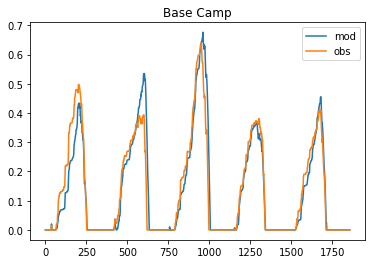

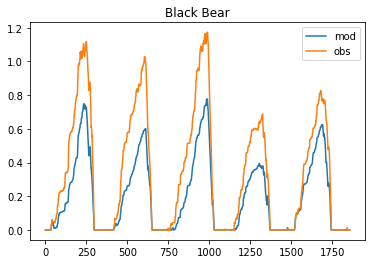

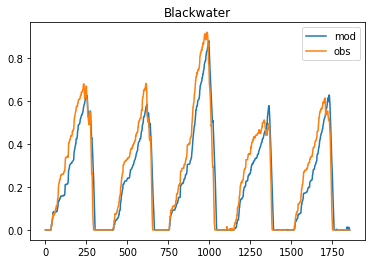

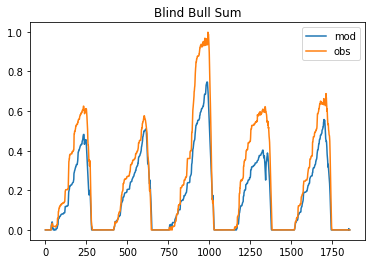

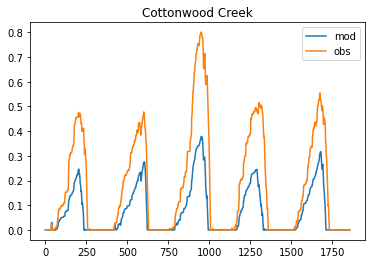

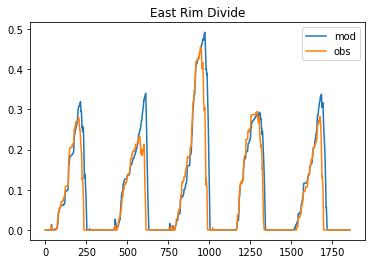

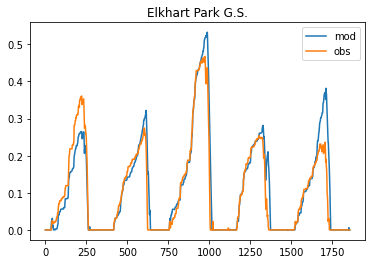

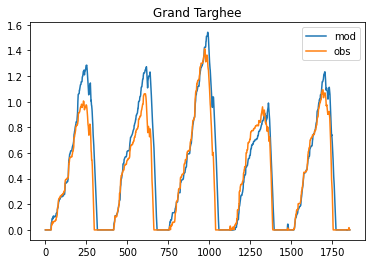

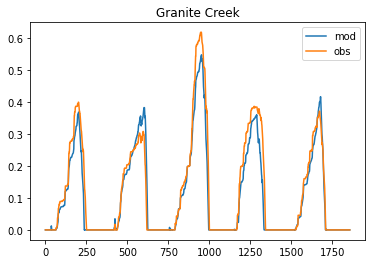

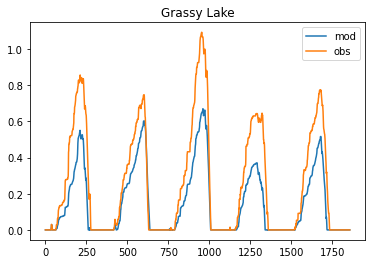

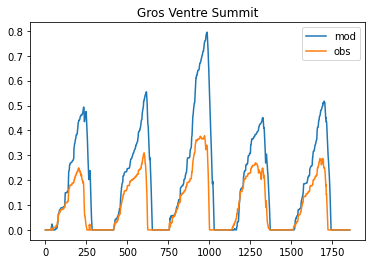

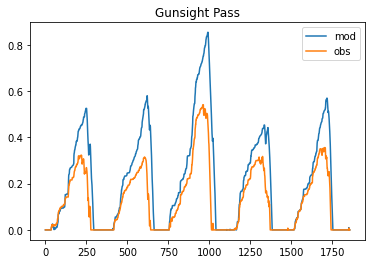

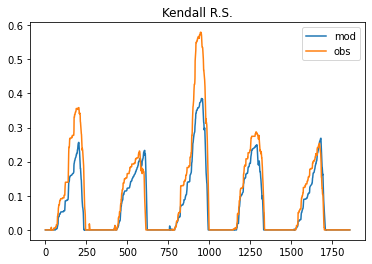

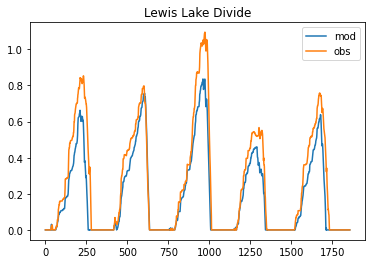

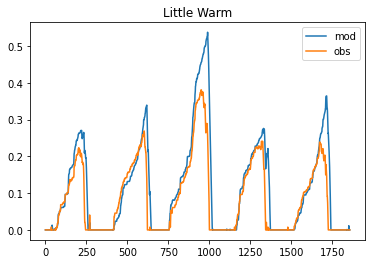

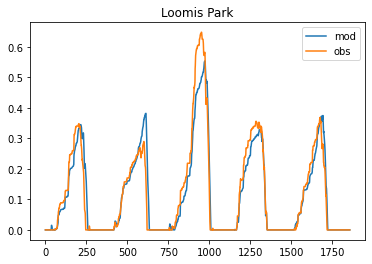

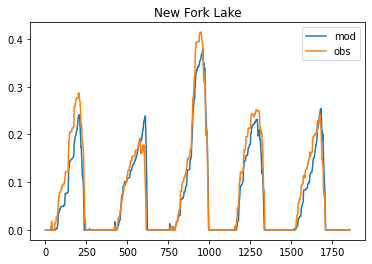

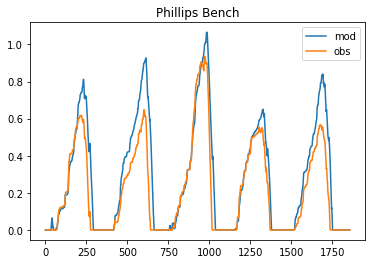

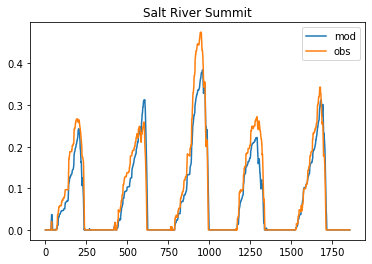

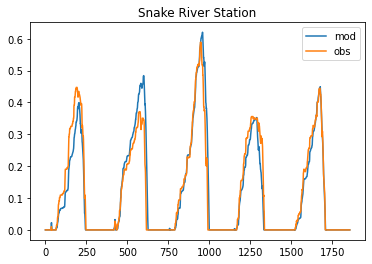

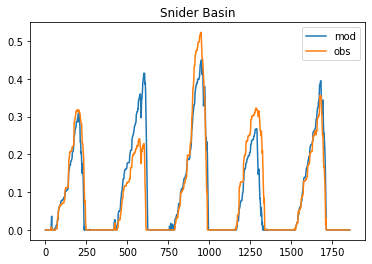

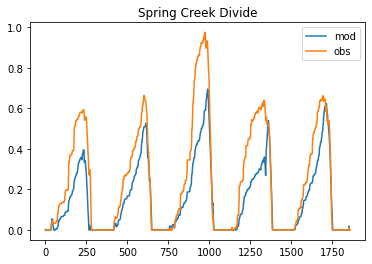

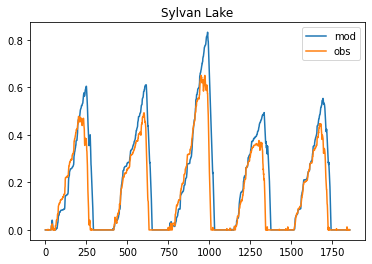

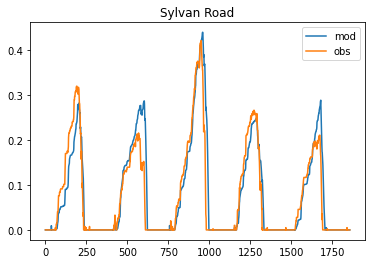

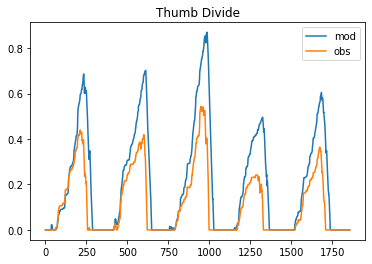

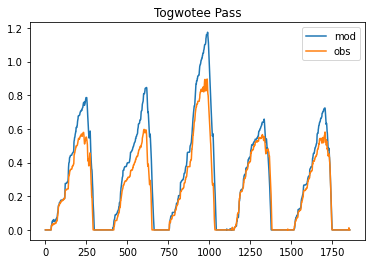

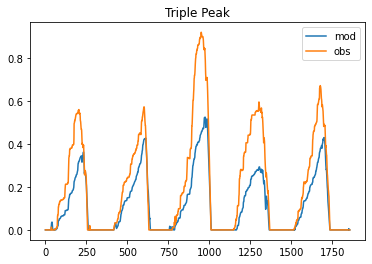

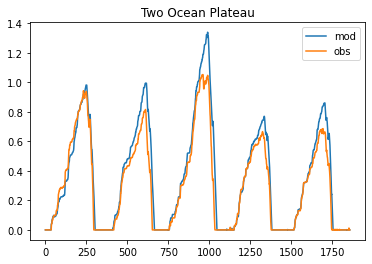

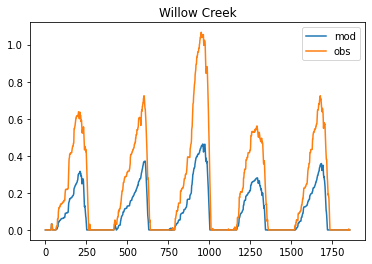

In [129]:
#test plot 
for i in range(np.shape(gdf)[0]):
    mod_swe = get_mod_output_lines(sweFile)
    mod_swe_stn = mod_swe[:,i]
    loc = gdf['code'][i]
    stn_swe = df[loc].values
    fig, ax = plt.subplots()
    ax.plot(mod_swe_stn,label='mod')
    ax.plot(stn_swe,label='obs')
    ax.legend()
    ax.set_title(gdf['name'][i])

# Function for calculating performance statistics

MAke sure I am using the correct r -> look at stats notes


In [124]:
#compute model performance metrics
def calc_metrics():
    swe_stats = np.zeros((5,np.shape(gdf)[0]))
    
    for i in range(np.shape(gdf)[0]):
        mod_swes = get_mod_output_lines(sweFile)
        mod_swe = mod_swes[:,i]
        loc = gdf['code'][i]
        stn_swe = df[loc].values
        
        #remove days with zero SWE at BOTH the station and the SM pixel
        idx = np.where((stn_swe != 0) & (mod_swe != 0))
        mod_swe = mod_swe[idx]
        stn_swe = stn_swe[idx]
        
        #remove days where station has nan values 
        idx = np.where(~np.isnan(stn_swe))
        mod_swe = mod_swe[idx]
        stn_swe = stn_swe[idx]
        
        #R-squared value
        swe_stats[0,i] = r2_score(stn_swe, mod_swe)

        #mean bias error
        swe_stats[1,i] = (sum(mod_swe - stn_swe))/mod_swe.shape[0]

        #root mean squared error
        swe_stats[2,i] = np.sqrt((sum((mod_swe - stn_swe)**2))/mod_swe.shape[0])

        # Nash-Sutcliffe model efficiency coefficient, 1 = perfect, assumes normal data 
        nse_top = sum((mod_swe - stn_swe)**2)
        nse_bot = sum((stn_swe - mean(stn_swe))**2)
        swe_stats[3,i] = (1-(nse_top/nse_bot))

        # Kling-Gupta Efficiency, 1 = perfect
        kge_std = (np.std(mod_swe)/np.std(stn_swe))
        kge_mean = (mean(mod_swe)/mean(stn_swe))
        kge_r = corrcoef(stn_swe,mod_swe)[1,0]
        swe_stats[4,i] = (1 - (sqrt((kge_r-1)**2)+((kge_std-1)**2)+(kge_mean-1)**2))
        
    return swe_stats

swe_stats = calc_metrics()

In [125]:
gdf['r2'] = swe_stats[0,:]
gdf['mbe'] = swe_stats[1,:]
gdf['rmse'] = swe_stats[2,:]
gdf['nse'] = swe_stats[3,:]
gdf['kge'] = swe_stats[4,:]

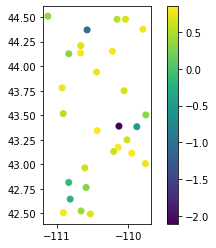

In [126]:
gdf.plot(column='r2',legend=True)

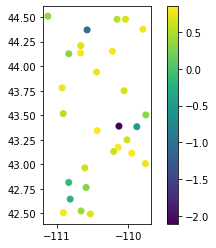

In [115]:
gdf.plot(column='nse',legend=True)

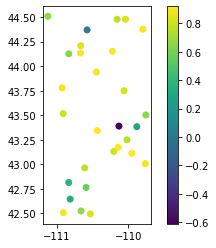

In [116]:
gdf.plot(column='kge',legend=True)

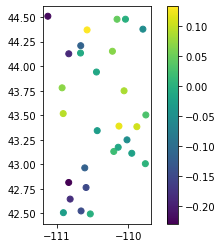

In [130]:
gdf.plot(column='mbe',legend=True)

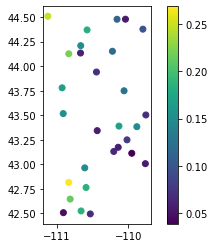

In [131]:
gdf.plot(column='rmse',legend=True)

# Create dataframe of calibration parameters

Add the vegetation parameters


In [153]:
#Calibration parameters

#snowfall_frac = [1,2,3]
#if = 1 -> 
#T_threshold = arange(float(base ['T_threshold'][0])-2,float(base ['T_threshold'][0])+2,1)
#if = 3 -> base['T_Left,T_Right']
#figure out how to parse these 

#snowfall_frac = [3]
#T_L_R = [base['T_Left,T_Right'][0],'-2,1','-2,2','-2,3','-1,1','-1,2','-1,3','0,2','0,3']


# wind_lapse_rate = arange(float(base ['wind_lapse_rate'][0]),
#                  float(base ['wind_lapse_rate'][0])+2.5,.5)

gap_frac = arange(0,1,.2)

#lat_solar_flag = [0,1]

#cannot use lonwave or shortwave obs with barnes large domain flag needed to run line mode of SM
# use_shortwave_obs = [0,1]

# use_longwave_obs = [0,1]

# lapse_rate= [base['lapse_rate'][0],
#              '.28,1.2,2.8,4.2,4.5,4.4,4.0,3.8,3.7,3.4,2.6,0.87']
# prec_lapse_rate = [base ['prec_lapse_rate'][0],
#                    '0.4,0.4,0.46,0.41,0.27,0.24,0.21,0.17,0.22,0.32,0.43,0.39']

ro_snowmax=arange(float(base ['ro_snowmax'][0])-200,
                  float(base ['ro_snowmax'][0])+175,50)

cf_precip_scalar=arange(float(base ['cf_precip_scalar'][0])-.4,
                        float(base ['cf_precip_scalar'][0])+.5,.1)
# add cf_precip_flag = 3
ro_adjust=arange(float(base ['ro_adjust'][0])-1,
                 float(base ['ro_adjust'][0])+2,1)

conifer_lai = arange(1.8,3.6,0.2)

Total_runs = len(gap_frac) * len(conifer_lai) * \
len(ro_snowmax)*len(cf_precip_scalar)*len(ro_adjust)
print('Total number of calibration runs = ',Total_runs)

# in the test model run -> get the wall time to estimate how long the calibration will take
wall_time = total_time
print('This will take approximately',Total_runs*wall_time/60/60,'hours')

Total number of calibration runs =  9720
This will take approximately 66.64119186401368 hours


In [155]:
parameters = [gap_frac,ro_snowmax,cf_precip_scalar,ro_adjust,conifer_lai]
data = list(itertools.product(*parameters))
input_params = pd.DataFrame(data,columns=['gap_frac',
                                          'ro_snowmax','cf_precip_scalar','ro_adjust','conifer_lai'])


In [156]:
timestamp = str(datetime.date(datetime.now()))+'_full_set'

#save input parameters as csv
input_params.to_csv(outpath+'cal_params_'+timestamp+'.csv',index=False)

# Run calibration

In [161]:
%%time
%cd $SMpath

top_swe = np.empty([len(input_params),num_sim_days,np.shape(gdf)[0]])        
swe_stats = np.empty([shape(input_params)[0],5,np.shape(gdf)[0]])

for i in range(2):#(np.shape(input_params)[0]):
    print(i+1, 'of', Total_runs)
    edit_par(base,'gap_frac',input_params.gap_frac[i],parFile)
    edit_par(base,'ro_snowmax',input_params.ro_snowmax[i],parFile)
    edit_par(base,'cf_precip_scalar',input_params.cf_precip_scalar[i],parFile)
    edit_par(base,'ro_adjust',input_params.ro_adjust[i],parFile)
    edit_par(base,'gap_frac',input_params.gap_frac[i],parFile)
    replace_line(micrometFile, 3336,'      data vlai_summer /'+str(input_params.conifer_lai[i])+', 2.5, 2.5, 1.5, 1.0/\n')
    replace_line(micrometFile, 3337,'      data vlai_winter /'+str(input_params.conifer_lai[i])+', 0.5, 1.5, 1.5, 1.0/\n')
    %cd $codepath
    #run compile script 
    ! ./compile_snowmodel.script
    %cd $SMpath
    ! nohup ./snowmodel
    swe_stats[i,:,:] = calc_metrics()
    mod_swe = get_mod_output_lines(sweFile)
    top_swe[i,:,:] = mod_swe

%cd $calpath

/nfs/attic/dfh/Aragon2/CSOsm/jan2021_snowmodel-dfhill_WY
0 of 9720
/nfs/attic/dfh/Aragon2/CSOsm/jan2021_snowmodel-dfhill_WY/code
/nfs/attic/dfh/Aragon2/CSOsm/jan2021_snowmodel-dfhill_WY
nohup: ignoring input and appending output to ‘nohup.out’
1 of 9720
/nfs/attic/dfh/Aragon2/CSOsm/jan2021_snowmodel-dfhill_WY/code
/nfs/attic/dfh/Aragon2/CSOsm/jan2021_snowmodel-dfhill_WY
nohup: ignoring input and appending output to ‘nohup.out’
/nfs/attic/dfh/Aragon2/Notebooks/calibration_python
CPU times: user 405 ms, sys: 166 ms, total: 570 ms
Wall time: 49.5 s


In [ ]:
%%time
%cd $SMpath

top_swe = np.empty([len(input_params),num_sim_days,np.shape(gdf)[0]])        
swe_stats = np.empty([shape(input_params)[0],5,np.shape(gdf)[0]])

for i in range(np.shape(input_params)[0]):
    print(i, 'of', Total_runs)
#     edit_par(base,'lat_solar_flag',input_params.lat_solar_flag[i])
#     edit_par(base,'use_shortwave_obs',input_params.use_shortwave_obs[i])
#     edit_par(base,'use_longwave_obs',input_params.use_longwave_obs[i])
#     edit_par(base,'lapse_rate',input_params.lapse_rate[i])
#     edit_par(base,'prec_lapse_rate',input_params.prec_lapse_rate[i])
    edit_par(base,'wind_lapse_rate',input_params.wind_lapse_rate[i])
    edit_par(base,'ro_snowmax',input_params.ro_snowmax[i])
    edit_par(base,'cf_precip_scalar',input_params.cf_precip_scalar[i])
    edit_par(base,'ro_adjust',input_params.ro_adjust[i])
    edit_par(base,'gap_frac',input_params.gap_frac[i])
    ! nohup ./snowmodel
    swe_stats[i,:,:] = calc_metrics()
    mod_swe = get_mod_output_lines(sweFile)
    top_swe[i,:,:] = mod_swe
    #print(swe_stats[i,:,:])

%cd $calpath

In [ ]:
#### correction for when there is a 1d array
# %%time
# %cd $SMpath

# if len(gdf) == 1:
#     top_swe = np.empty([len(input_params),num_sim_days])
#     else:
#         top_swe = np.empty([len(input_params),num_sim_days,np.shape(gdf)[0]])

# swe_stats = np.empty([shape(input_params)[0],5,np.shape(gdf)[0]])

# for i in range(np.shape(input_params)[0]):
#     print(i, 'of', Total_runs)
# #     edit_par(base,'lat_solar_flag',input_params.lat_solar_flag[i])
# #     edit_par(base,'use_shortwave_obs',input_params.use_shortwave_obs[i])
# #     edit_par(base,'use_longwave_obs',input_params.use_longwave_obs[i])
# #     edit_par(base,'lapse_rate',input_params.lapse_rate[i])
# #     edit_par(base,'prec_lapse_rate',input_params.prec_lapse_rate[i])
#     edit_par(base,'wind_lapse_rate',input_params.wind_lapse_rate[i])
#     edit_par(base,'ro_snowmax',input_params.ro_snowmax[i])
#     edit_par(base,'cf_precip_scalar',input_params.cf_precip_scalar[i])
#     edit_par(base,'ro_adjust',input_params.ro_adjust[i])
#     edit_par(base,'gap_frac',input_params.gap_frac[i])
#     ! nohup ./snowmodel
#     swe_stats[i,:,:] = calc_metrics()
#     mod_swe = get_mod_output_lines(sweFile)
#     if len(gdf) == 1:
#         top_swe[i,:] = mod_swe
#         else:
#             top_swe[i,:,:] = mod_swe
#     #print(swe_stats[i,:,:])

# %cd $calpath

In [ ]:
## running into a problem when just using one station for calibration - need to adjust this
#np.ndim(mod_swe),np.ndim(top_swe)

# Save output as netcdf

In [162]:
#Turn NDarray into xarray 
calibration_run = np.arange(0,swe_stats.shape[0],1)
metric = ['R2','MBE','RMSE','NSE','KGE']
station = gdf['code'].values

cailbration = xr.DataArray(
    swe_stats,
    dims=('calibration_run', 'metric', 'station'), 
    coords={'calibration_run': calibration_run, 
            'metric': metric, 'station': station})

cailbration.attrs['long_name']= 'Calibration performance metrics'
cailbration.attrs['standard_name']= 'cal_metrics'

d = OrderedDict()
d['calibration_run'] = ('calibration_run', calibration_run)
d['metric'] = ('metric', metric)
d['station'] = ('station', station)
d['cal_metrics'] = cailbration

ds = xr.Dataset(d)
ds.attrs['description'] = "SnowModel line calibration performance metrics"
ds.attrs['calibration_parameters'] = "ro_snowmax,cf_precip_scalar,ro_adjust"
ds.attrs['model_parameter'] = "SWE [m]"

ds.calibration_run.attrs['standard_name'] = "calibration_run"
ds.calibration_run.attrs['axis'] = "N"

ds.metric.attrs['long_name'] = "calibration_metric"
ds.metric.attrs['axis'] = "metric"

ds.station.attrs['long_name'] = "station_id"
ds.station.attrs['axis'] = "station"

ds.to_netcdf(outpath+'calibration_'+timestamp+'.nc', format='NETCDF4', engine='netcdf4')

In [163]:
calibration_run = np.arange(0,top_swe.shape[0],1)
sim_day = np.arange(0,top_swe.shape[1],1)
station = gdf['code'].values

swe = xr.DataArray(
    top_swe,
    dims=('calibration_run', 'sim_day', 'station'), 
    coords={'calibration_run': calibration_run, 
            'sim_day': sim_day, 'station': station})

swe.attrs['long_name']= 'swe timeseries [m]'
swe.attrs['standard_name']= 'swe'

d = OrderedDict()
d['calibration_run'] = ('calibration_run', calibration_run)
d['sim_day'] = ('sim_day', sim_day)
d['station'] = ('station', station)
d['cal_metrics'] = swe

ds = xr.Dataset(d)
ds.attrs['description'] = "SnowModel swe"
ds.attrs['model_parameter'] = "SWE [m]"

ds.calibration_run.attrs['standard_name'] = "calibration_run"
ds.calibration_run.attrs['axis'] = "N"

ds.sim_day.attrs['long_name'] = "sumilation_day"
ds.sim_day.attrs['axis'] = "sim_day"

ds.station.attrs['long_name'] = "station_id"
ds.station.attrs['axis'] = "station"

ds.to_netcdf(outpath+'swe_'+timestamp+'.nc', format='NETCDF4', engine='netcdf4')